### Berth allocation problem

1910101

In [395]:
import pandas as pd
import numpy as np
import operator
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib import colors

@dataclass()
class Node:
    time: int          # time axis -- rename needed
    pos: int          # position axis
    cls: np.array  # type: ignore

    def __eq__(self, other):
        return self.time == other.time and self.pos == other.pos and np.array_equal(self.cls, other.cls)

    def __key(self):
        return (self.time, self.pos, str(list(self.cls)))

    def __hash__(self):
        return hash(self.__key())

    def __str__(self):
        return "{ %d, %d, %s }" % (self.time, self.pos, 'lower' if self.cls[0] == 1 else 'upper')


Import the input

In [457]:
with open('input1.txt', 'r') as file:
    infos = file.read().split("\n\n")
    berth_len = int(infos[0].split("\n")[1])
    berth_breaks_list = [int(x) for x in infos[1].split("\n")[1:]]
    vessels_list = [line.split("\t") for line in infos[2].split("\n")[1:-1]]

print(f"""Berth len: {berth_len}
Berth breaks: {berth_breaks_list}""")

vessels_df = pd.DataFrame.from_dict({
    "size_": [int(v[1]) for v in vessels_list],
    "t_arrive": [int(v[2]) for v in vessels_list],
    "t_process": [int(v[3]) for v in vessels_list],
    "weight": [int(v[4]) if len(v) == 5 else 1 for v in vessels_list],
})
vessels_df.index += 1
print(vessels_df)

['%  Berth length\n40', '% Berth breaks\n20\n32', '% Vessel index, size, arrival time, processing time, weight (=1 as default) \n1\t10\t10\t10\n2\t15\t5\t9\t2\n3\t6\t0\t5\n4\t20\t2\t10\t3\n5\t5\t15\t5\n6\t15\t12\t8\n7\t7\t8\t10\t3\n']
Berth len: 40
Berth breaks: [20, 32]
   size_  t_arrive  t_process  weight
1     10        10         10       1
2     15         5          9       2
3      6         0          5       1
4     20         2         10       3
5      5        15          5       1
6     15        12          8       1
7      7         8         10       3


In [273]:
sorted_df = vessels_df.sort_values(by=['t_arrive'])
print(sorted_df)

   size_  t_arrive  t_process  weight
3      6         0          5       1
4     20         2         10       3
2     15         5          9       2
7      7         8         10       3
1     10        10         10       1
6     15        12          8       1
5      5        15          5       1


Moore vessels in a first-come-first-serve manner

Construction phase  
  1. Input the packing of previous `n-1` vessels and (size, t_arrive, t_process) of vessel `n` 
  2. Classify nodes within ABCD to 5 classes, turn `[1,0,1,0]` and `[0,1,0,1]` nodes into Class1's
  3. Group C1 = `[1,0,0,0]` and `[0,0,0,1]` nodes, C3 = Class3 nodes
  4. Extend nodes in C3 to edges of the hole, add intersections to I1 and I2, update I1 and I2 vectors accordingly
  5. Test feasibility & optimality in C1 + I1 + I2 nodes
     
Assume that there are `k` feasible positions, calculate Cost = sum(w(c - a)) for each position, filter "bad" positions relative to others. 
    
After screening, use a probability to choose the berth position among the candidates.

In [441]:
TIME_HORIZON = 40
ABCD_right = TIME_HORIZON
ABCD_top = berth_len
ABCD_bot = 0

def generate_packing():

    packing = pd.DataFrame.from_dict({
        "vessel_idx": [],
        "t_moore": [],
        "t_finish": [],
        "p_start": [],
        "p_end": []
    })

    # Take packing info and current vessel info
    for row in sorted_df.index:
        vessel = sorted_df.loc[row]
        print(f"🛳️Vessel_{row}, 📏{vessel.size_}, ⏱️{vessel.t_arrive}~{vessel.t_process}.")

        # If this cut through a block then it is a moore point
        ABCD_left = vessel.t_arrive

        # Set of vertical and horizontal lines to construct grid
        verticals = set([ABCD_left, ABCD_right])
        horizontals = set([ABCD_bot, ABCD_top])
        
        v_blobs = []
        h_blobs = []

        # Construct grid
        for idx in packing.index:
            rect = packing.loc[idx]
            if rect.t_finish > ABCD_left:
                verticals.add(rect.t_finish)
                horizontals.add(rect.p_start)  # type: ignore
                horizontals.add(rect.p_end)  # type: ignore

                h_blobs.append((rect.p_start, rect.p_end))
                v_blobs.append((max([rect.t_moore, ABCD_left]), rect.t_finish))  # type: ignore

            if rect.t_moore > ABCD_left:
                verticals.add(rect.t_moore)

        # Classify nodes
        t_moore_s = list(set(packing.t_moore.add(ABCD_left)))
        t_moore_s.sort() 
        t_finish_es = list(set(packing.t_finish))
        t_finish_es.sort() 
        p_start_s = list(set(packing.p_start))
        p_start_s.sort() 
        p_end_s = list(set(packing.p_end))
        p_end_s.sort() 
        nodes = []
        for time in verticals:
            for pos in horizontals:
                new_node = Node(time, pos, np.array([1, 1, 1, 1])) # type: ignore
                constraint = np.array([
                    time in t_moore_s and pos in p_start_s or time >= ABCD_right or pos >= ABCD_top,
                    time in t_finish_es and pos in p_start_s or time <= ABCD_left or pos >= ABCD_top,
                    time in t_finish_es and pos in p_end_s or time <= ABCD_left or pos <= ABCD_bot,
                    time in t_moore_s and pos in p_end_s or time >= ABCD_right or pos <= ABCD_bot
                ])
                new_node.cls -= constraint
                
                # Add missing vincinities
                v_overlap = list(filter(lambda bounds: bounds[1][0] <= time and time <= bounds[1][1], enumerate(v_blobs)))
                h_overlap = [h_blobs[i] for i,_ in v_overlap]
                v_overlap = [v for _,v in v_overlap]
                for vb, hb in zip(v_overlap, h_overlap):
                    if hb[0] > pos or pos > hb[1]:
                        continue
                    vin = np.array([
                        not(time < vb[1] and pos < hb[1]),
                        not(time > vb[0] and pos < hb[1]),
                        not(time > vb[0] and pos > hb[0]),
                        not(time > vb[1] and pos > hb[0]),
                    ])
                    new_node.cls *= vin

                # Turn Class 2 node into Class 1 nodes
                if np.array_equal(new_node.cls, np.array([1,0,1,0])):
                    nodes.append(Node(new_node.time, new_node.pos, np.array([1,0,0,0])))
                    nodes.append(Node(new_node.time, new_node.pos, np.array([0,0,1,0])))
                elif np.array_equal(new_node.cls, np.array([0,1,0,1])):
                    nodes.append(Node(new_node.time, new_node.pos, np.array([0,1,0,0])))
                    nodes.append(Node(new_node.time, new_node.pos, np.array([0,0,0,1])))
                else:
                    nodes.append(new_node)


        # Grouping nodes to form a list of possible corner to stuck the next vessel in
        C1 = list(filter(
            lambda node: np.array_equal(node.cls, [1,0,0,0]) or np.array_equal(node.cls, [0,0,0,1]), nodes))
        C3 = list(filter(lambda node: np.sum(node.cls) == 3, nodes))
        I1 = []
        for node in C3:
            if node.cls[0] == 0:
                ## Extend leftwards
                same_pos_nodes = list(filter(lambda n: n.pos == node.pos, nodes))
                same_pos_nodes.sort(key=operator.attrgetter("time"), reverse=True)
                ## Get the first node that is not a Class4 (empty space) node
                extended = next(filter(lambda n: n.time < node.time and sum(n.cls) != 4, same_pos_nodes))
                I1.append(Node(extended.time, extended.pos, np.array([0,0,0,1])))
            
            elif node.cls[3] == 0:
                ## Extend leftwards
                same_pos_nodes = list(filter(lambda n: n.pos == node.pos, nodes))
                same_pos_nodes.sort(key=operator.attrgetter("time"), reverse=True)
                extended = next(filter(lambda n: n.time < node.time and sum(n.cls) != 4, same_pos_nodes))
                I1.append(Node(extended.time, extended.pos, np.array([1,0,0,0])))

            elif node.cls[1] == 0:
                ## Extend downwards
                same_time_nodes = list(filter(lambda n: n.time == node.time, nodes))
                same_time_nodes.sort(key=operator.attrgetter("pos"), reverse=True)
                extended = next(filter(lambda n: n.pos < node.pos and sum(n.cls) != 4, same_time_nodes))
                I1.append(Node(extended.time, extended.pos, np.array([1,0,0,0])))

            else:
                ## Extend upwards
                same_time_nodes = list(filter(lambda n: n.time == node.time, nodes))
                same_time_nodes.sort(key=operator.attrgetter("pos"))
                extended = next(filter(lambda n: n.pos > node.pos and sum(n.cls) != 4, same_time_nodes))
                I1.append(Node(extended.time, extended.pos, np.array([0,0,0,1])))
        

        # Intersections of lines in I1, can defer this and do this later
        I2 = [] 
        POSSIBLE = list(set(I1 + C1))


        # Test feasibility
        pruned_list = []
        for position in POSSIBLE:
            time_range = (position.time, position.time + vessel.t_process)
            pos_range = (position.pos, position.pos + vessel.size_) if position.cls[0] else \
                        (position.pos - vessel.size_, position.pos)
            if pos_range[1] > berth_len:
                continue
            # Check if this range overlap any blobs
            idx_v_overlap = list(filter(lambda bounds: bounds[1][0] < time_range[1] and time_range[0] < bounds[1][1], enumerate(v_blobs)))
            h_ = [h_blobs[i] for i, _ in idx_v_overlap]
            h_overlap = list(filter(lambda bounds: bounds[0] < pos_range[1] and pos_range[0] < bounds[1], h_))
            v_overlap = [v for _, v in idx_v_overlap]
            if len(h_overlap) != 0:
                print(f"{position} overlap with {h_overlap}, {v_overlap}")
            else:
                pruned_list.append(position)
        POSSIBLE = pruned_list

        # Test optimality: for same positions and class, nodes that starts sooner is better
                   


        # Calculate cost of the above positions
        makespans = []
        for position in POSSIBLE:
            if len(packing.t_finish) == 0:
                break
            min_ws = 0
            this_t_finish = packing.t_finish.copy() + [position.time + vessel.t_process]
            makespans.append(max(sorted_df.weight[:len(this_t_finish)] * np.array(this_t_finish)))
        min_pos = np.argmin(makespans) if len(makespans) else 0


        # Filter worse positions
        # Choose one position acc. to a probability

        position = POSSIBLE[min_pos]
        print(f"Place into {position}")
        packing.loc[len(packing.index)] = [  # type: ignore
            row,
            position.time, 
            position.time + vessel.t_process, 
            position.pos if position.cls[0] else position.pos - vessel.size_,
            position.pos + vessel.size_ if position.cls[0] else position.pos
        ]

        result = packing.tail(1)
        print(f"⚓Vessel_{row}, 📌{int(result.p_start)}-{int(result.p_end)}, ⌛{int(result.t_moore)}-{int(result.t_finish)}.")

        # print("💡Positions: " + ",".join([str(p) for p in POSSIBLE]))
        # print(nodes)
        # print("💡Possible positions: ", POSSIBLE)
        # print(C1, C3)
        print("")

    print("Makespan: ", max(packing.t_finish))
    print("Weighted makespan: ", max(np.array(sorted_df.weight) * np.array(packing.t_finish)))

    return packing


In [368]:
packing.tail(1).t_moore

6    21
Name: t_moore, dtype: int64

In [442]:
# Visualization
res = generate_packing()


🛳️Vessel_3, 📏6, ⏱️0~5.
Place into { 0, 0, lower }
⚓Vessel_3, 📌0-6, ⌛0-5.

🛳️Vessel_4, 📏20, ⏱️2~10.
Place into { 2, 6, lower }
⚓Vessel_4, 📌6-26, ⌛2-12.

🛳️Vessel_2, 📏15, ⏱️5~9.
{ 5, 40, upper } overlap with [(6, 26)], [(5, 12)]
Place into { 12, 0, lower }
⚓Vessel_2, 📌0-15, ⌛12-21.

🛳️Vessel_7, 📏7, ⏱️8~10.
{ 12, 6, upper } overlap with [(0, 15)], [(12, 21)]
Place into { 8, 40, upper }
⚓Vessel_7, 📌33-40, ⌛8-18.

🛳️Vessel_1, 📏10, ⏱️10~10.
{ 10, 26, lower } overlap with [(33, 40)], [(10, 12), (12, 21), (10, 18)]
{ 10, 33, upper } overlap with [(6, 26)], [(10, 12), (12, 21), (10, 18)]
Place into { 12, 15, lower }
⚓Vessel_1, 📌15-25, ⌛12-22.

🛳️Vessel_6, 📏15, ⏱️12~8.
{ 21, 33, upper } overlap with [(15, 25)], [(12, 22)]
{ 12, 25, lower } overlap with [(33, 40)], [(12, 21), (12, 18), (12, 22)]
{ 18, 33, upper } overlap with [(15, 25)], [(12, 21), (12, 22)]
{ 18, 15, upper } overlap with [(0, 15)], [(12, 21), (12, 22)]
{ 12, 33, upper } overlap with [(15, 25)], [(12, 21), (12, 18), (12, 22)]
Pla

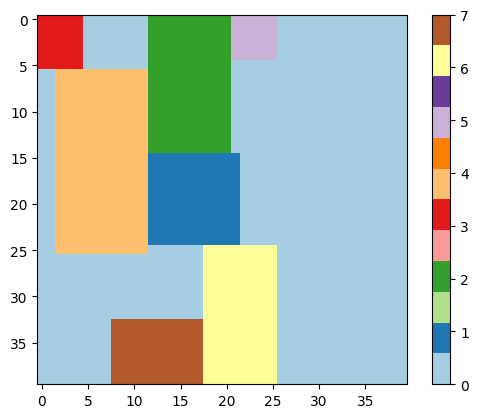

In [458]:
# Just some example data (random)
data = np.zeros((berth_len, TIME_HORIZON))

for idx in res.index:
    row = res.loc[idx]
    data[row.p_start:row.p_end, row.t_moore:row.t_finish] = row.vessel_idx

rows,cols = data.shape

fig = plt.imshow(data, interpolation='nearest', cmap='Paired', origin="upper")
plt.colorbar(fig)

plt.show()